# Facial Emotion Recognition - XCeption Model

## Import Libraries

In [13]:
### General imports ###
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from time import sleep
import re
import os
import argparse
from collections import OrderedDict
import matplotlib.animation as animation

### Image processing ###
from scipy.ndimage import zoom
from scipy.spatial import distance
import imutils
from scipy import ndimage
import cv2
import dlib
from imutils import face_utils

### Deep Learning models ###
import keras
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, SeparableConv2D
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, SeparableConv2D, ZeroPadding2D, UpSampling2D, BatchNormalization, Input, GlobalAveragePooling2D, AveragePooling2D
#from tensorflow. keras.utils import np_utils
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import models
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import layers
from tensorflow.keras.applications import densenet
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
### Same trained models ###
import h5py
from keras.models import model_from_json
import pickle

## Import Data

In [3]:

path = "/Users/ashrafmahmoud/Documents/ITI/9 Months/Core courses/Computer Vision/Projects/Emotion_Recognition_XCeption/challenges-in-representation-learning-facial-expression-recognition-challenge/"
folder_path = path + "Preprocessing_data/"

X_train = np.load(folder_path + "X_train.npy")
X_test = np.load(folder_path + "X_test.npy")
y_train = np.load(folder_path + "y_train.npy")
y_test = np.load(folder_path + "y_test.npy")

In [4]:
shape_x = 48
shape_y = 48
nRows, nCols, nDims = X_train.shape[1:]
input_shape = (nRows, nCols, nDims) 
classes = np.unique(y_train)
num_classes = len(classes)

## Xception Model

![Transformer Architecture](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*LQAC3xL5XL1x8TsIOChM7A.jpeg)

In [5]:
def entry_flow(inputs):
    
    x = Conv2D(32, 3, strides = 2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64,3,padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    previous_block_activation = x

    for size in [128, 256, 728] :
    
        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)
    
        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)
        
        x = MaxPooling2D(3, strides=2, padding='same')(x)
        
        residual = Conv2D(size, 1, strides=2, padding='same')(previous_block_activation)
        
        x = keras.layers.Add()([x, residual])
        previous_block_activation = x
    
    return x

In [6]:
def middle_flow(x, num_blocks=8) :
    
    previous_block_activation = x
    
    for _ in range(num_blocks) :
    
        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)
    
        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)
        
        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)
        
        x = keras.layers.Add()([x, previous_block_activation])
        previous_block_activation = x
    
    return x

In [7]:
def exit_flow(x, num_classes=7) :
    
    previous_block_activation = x
    
    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    
    residual = Conv2D(1024, 1, strides=2, padding='same')(previous_block_activation)
    x = keras.layers.Add()([x, residual])
      
    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)
    
    return x

In [14]:
inputs = Input(shape=(shape_x, shape_y, 1))
outputs = exit_flow(middle_flow(entry_flow(inputs)))

In [15]:
xception = Model(inputs, outputs)

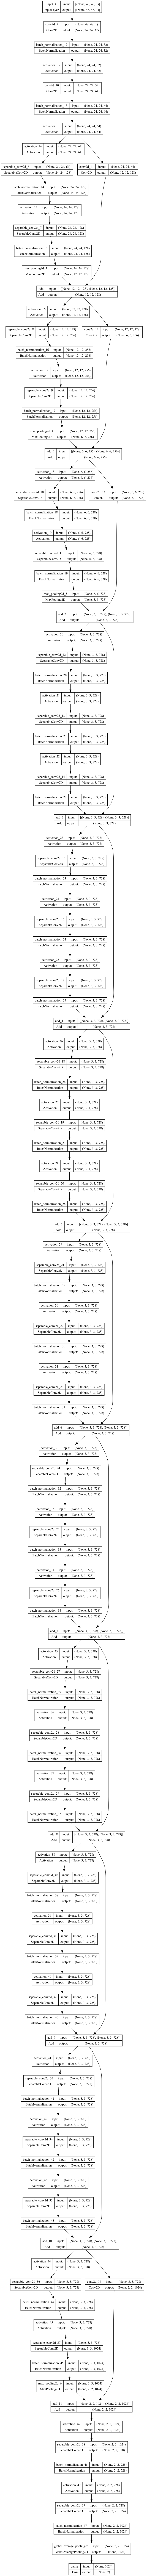

In [20]:
plot_model(xception, to_file='/Users/ashrafmahmoud/Documents/ITI/9 Months/Core courses/Computer Vision/Projects/Emotion_Recognition_XCeption/Images/model.png', show_shapes=True, show_layer_names=True)

In [14]:
xception.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 24, 24, 32)   320         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_36 (BatchN  (None, 24, 24, 32)  128         ['conv2d_6[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 activation_36 (Activation)     (None, 24, 24, 32)   0           ['batch_normalization_36[0][0

In [17]:
xception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
 
batch_size = 128
epochs = 150

In [ ]:
datagen = ImageDataGenerator(
        zoom_range=0.2,          # randomly zoom into images
        rotation_range=10,       # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,    # randomly flip images
        vertical_flip=False)     # randomly flip images

history = xception.fit_generator(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=int(np.ceil(X_train.shape[0] / float(batch_size))),
    epochs = epochs, 
    validation_data=(X_test, y_test)
)

## Model Evaluation

In [ ]:
#Plotting accuracy and loss curves for 2nd model

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=2.0)
plt.plot(history.history['val_acc'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

## Save the model

In [ ]:
Models_folder = "/Users/ashrafmahmoud/Documents/ITI/9 Months/Core courses/Computer Vision/Projects/Emotion_Recognition_XCeption/Models/"

In [ ]:
#save the model weights
json_string = model.to_json()
model.save_weights(Models_folder + 'EmotionRecognition/xception_model.h5')
open(Models_folder + 'EmotionRecognition/xception_model.json', 'w').write(json_string)
#model.save_weights(Models_folder + 'EmotionRecognition/xception_model.h5')